In [6]:
import sys
sys.path.append('E:/tennis_v2/')
print(sys.path)
import os
import cv2
import torch
import pathlib
import torchvision.transforms as transforms
import numpy as np
import pandas as pd

from model.wasb import HRNet
from utils.kalman_filter import KalmanFilter
from utils.LoadData import resize_feature
from model.bounce_detector import BounceDetector
from collections import deque
from assets.bounce import detect_bounces
import matplotlib.pyplot as plt

# from asset.tennis_v1.LoadData import resize_feature

%load_ext autoreload
%autoreload 2

['D:\\python\\Python3106-64', 'd:\\python\\Python3106-64\\python310.zip', 'd:\\python\\Python3106-64\\DLLs', 'd:\\python\\Python3106-64\\lib', '', 'C:\\Users\\10765\\AppData\\Roaming\\Python\\Python310\\site-packages', 'C:\\Users\\10765\\AppData\\Roaming\\Python\\Python310\\site-packages\\win32', 'C:\\Users\\10765\\AppData\\Roaming\\Python\\Python310\\site-packages\\win32\\lib', 'C:\\Users\\10765\\AppData\\Roaming\\Python\\Python310\\site-packages\\Pythonwin', 'd:\\python\\Python3106-64\\lib\\site-packages', 'd:\\python\\Python3106-64\\lib\\site-packages\\stable_diffusion-0.0.1-py3.10.egg', 'd:\\python\\Python3106-64\\lib\\site-packages\\k_diffusion-0.2.0.dev0-py3.10.egg', 'd:\\python\\Python3106-64\\lib\\site-packages\\wandb-0.17.5-py3.10.egg', 'd:\\python\\Python3106-64\\lib\\site-packages\\dctorch-0.1.2-py3.10.egg', 'd:\\python\\Python3106-64\\lib\\site-packages\\clip_anytorch-2.6.0-py3.10.egg', 'd:\\python\\Python3106-64\\lib\\site-packages\\setproctitle-1.3.3-py3.10-win-amd64.egg'

In [3]:
# --- Constants and Configuration ---
CURRENT_DIR = 'E:/tennis_v2/'
MODEL_PATH = f"{CURRENT_DIR}/weights/wasb_tennis_best.pth"
BOUNCE_DETECTOR_PATH = f"{CURRENT_DIR}/weights/ctb_regr_bounce.cbm"
DELAY = 15  # 延迟帧数

csv = 'test_02'
video_input_path = 'e:/TennisProject-main/inference/test_02.mp4'
video_output_path = 'e:/tennis_v2/inference/HRnetv3_' + video_input_path.split('/')[-1]
output_csv_path = 'e:/tennis_v2/inference/HRnetv3_' + csv + '.csv'

In [7]:
current_dir = 'E:/tennis_v2/'

def preprocess_frame(frame, transform):
    return transform(frame)

def predict_ball_position(prev_positions, width, height):
    if len(prev_positions) < 3:
        return None
    p_t = prev_positions[-1]
    a_t = p_t - 2 * prev_positions[-2] + prev_positions[-3]
    v_t = p_t - prev_positions[-2] + a_t
    predicted_position = p_t + v_t + 0.5 * a_t
    predicted_position = np.clip(predicted_position, [0, 0], [width, height])
    return predicted_position

def run_inference(input_path, output_path="", output_csv_path="", overlay=False):
    config = {
        "name": "hrnet",
        "frames_in": 3,
        "frames_out": 3,
        "inp_height": 288,
        "inp_width": 512,
        "out_height": 288,
        "out_width": 512,
        "rgb_diff": False,
        "out_scales": [0],
        "MODEL": {
            "EXTRA": {
                "FINAL_CONV_KERNEL": 1,
                "PRETRAINED_LAYERS": ['*'],
                "STEM": {
                    "INPLANES": 64,
                    "STRIDES": [1, 1]
                },
                "STAGE1": {
                    "NUM_MODULES": 1,
                    "NUM_BRANCHES": 1,
                    "BLOCK": 'BOTTLENECK',
                    "NUM_BLOCKS": [1],
                    "NUM_CHANNELS": [32],
                    "FUSE_METHOD": 'SUM'
                },
                "STAGE2": {
                    "NUM_MODULES": 1,
                    "NUM_BRANCHES": 2,
                    "BLOCK": 'BASIC',
                    "NUM_BLOCKS": [2, 2],
                    "NUM_CHANNELS": [16, 32],
                    "FUSE_METHOD": 'SUM'
                },
                "STAGE3": {
                    "NUM_MODULES": 1,
                    "NUM_BRANCHES": 3,
                    "BLOCK": 'BASIC',
                    "NUM_BLOCKS": [2, 2, 2],
                    "NUM_CHANNELS": [16, 32, 64],
                    "FUSE_METHOD": 'SUM'
                },
                "STAGE4": {
                    "NUM_MODULES": 1,
                    "NUM_BRANCHES": 4,
                    "BLOCK": 'BASIC',
                    "NUM_BLOCKS": [2, 2, 2, 2],
                    "NUM_CHANNELS": [16, 32, 64, 128],
                    "FUSE_METHOD": 'SUM'
                },
                "DECONV": {
                    "NUM_DECONVS": 0,
                    "KERNEL_SIZE": [],
                    "NUM_BASIC_BLOCKS": 2
                }
            },
            "INIT_WEIGHTS": True
        },
        "model_path": f"{current_dir}/weights/wasb_tennis_best.pth",  # Update with your model path
    }
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((config['inp_height'], config['inp_width'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    model = HRNet(cfg=config).to(device)
    checkpoint = torch.load(config['model_path'], map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'], strict=True)
    model.eval()

    # bounce model
    # bounce_model = Model().to(device)
    # bounce_model.load_state_dict(torch.load(f'{current_dir}/model_weight/model_state_dict_32_v3.pth'))
    # bounce_model.eval()  # 设置为评估模式

    bounce_detector = BounceDetector(f'{current_dir}/weights/ctb_regr_bounce.cbm')

    cap = cv2.VideoCapture(input_path)

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    base_name = os.path.splitext(os.path.basename(input_path))[0]
    if output_path == "":
        output_video_path = os.path.join(os.path.dirname(output_path))
    else:
        output_video_path = os.path.join(output_path)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, 1, (width, height))   # fps
    print(output_video_path)
    frame_number = 0
    frames_buffer = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    stable_frames_threshold = 1

    prev_positions = []
    positions = []


    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frames_buffer.append(frame)
        if len(frames_buffer) == config['frames_in']:
            # Preprocess the frames
            frames_processed = [preprocess_frame(f, transform) for f in frames_buffer]


            if frame_number == 81:    # 189
                input_tensor = torch.cat(frames_processed, dim=0).unsqueeze(0).to(device)

                # Perform inference
                with torch.no_grad():
                    outputs = model(input_tensor)[0]  # Get the raw logits
                return outputs.detach().cpu()
            
            frames_buffer = []
            frame_number += 3





In [8]:
outputs = run_inference(video_input_path, video_output_path, output_csv_path)

e:/tennis_v2/inference/HRnetv3_test_02.mp4


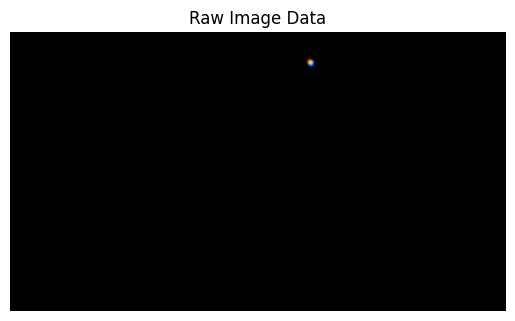

In [9]:
# 去掉 batch 维度： (3, 288, 512)
img_tensor = outputs[0]
img_tensor = torch.sigmoid(img_tensor)

# permute 到 (H, W, C)： (288, 512, 3)
img_tensor = img_tensor .permute(1, 2, 0)

img_np = img_tensor.numpy()

plt.imshow(img_np)
plt.title("Raw Image Data")
plt.axis("off")
plt.show()

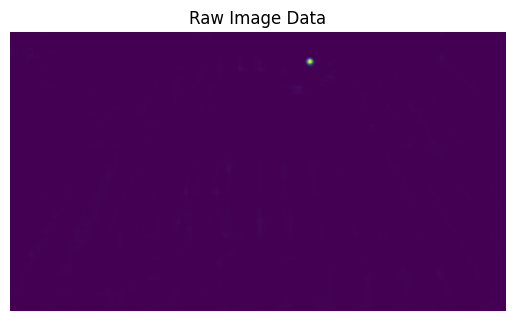

In [10]:
# 去掉 batch 维度： (3, 288, 512)
img_tensor_0 = outputs[0, 0]
img_tensor_0 = torch.sigmoid(img_tensor_0)

# permute 到 (H, W, C)： (288, 512, 3)
img_tensor_0  = img_tensor_0 .permute(0, 1)

img_np_0 = img_tensor_0.numpy()
plt.imshow(img_np_0)
plt.title("Raw Image Data")
plt.axis("off")
plt.show()

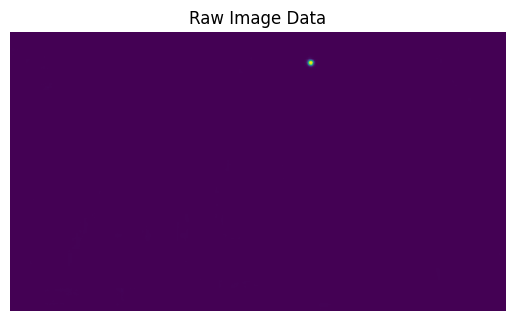

In [11]:
# 去掉 batch 维度： (3, 288, 512)
img_tensor_1 = outputs[0, 1]
img_tensor_1 = torch.sigmoid(img_tensor_1)

# permute 到 (H, W, C)： (288, 512, 3)
img_tensor_1  = img_tensor_1 .permute(0, 1)

img_np_1 = img_tensor_1.numpy()

plt.imshow(img_np_1)
plt.title("Raw Image Data")
plt.axis("off")
plt.show()


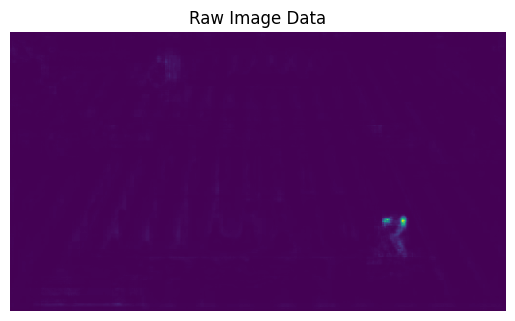

In [152]:
# 去掉 batch 维度： (3, 288, 512)
img_tensor_2 = outputs[0, 2]
img_tensor_2 = torch.sigmoid(img_tensor_2)

# permute 到 (H, W, C)： (288, 512, 3)
img_tensor_2  = img_tensor_2 .permute(0, 1)

img_np_2 = img_tensor_2.numpy()

plt.imshow(img_np_2)
plt.title("Raw Image Data")
plt.axis("off")
plt.show()

In [354]:
outputs[0].shape

torch.Size([3, 288, 512])

In [355]:
heatmap = torch.sigmoid(outputs[0][0]).squeeze().cpu().numpy()
print(outputs[0]. shape, heatmap.shape)

torch.Size([3, 288, 512]) (288, 512)


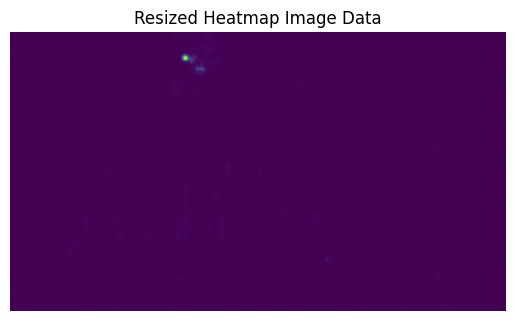

In [356]:
# 使用 cv2.resize 改变图像大小
heatmap_resized = cv2.resize(heatmap, (1280, 720), interpolation=cv2.INTER_LINEAR)


# 显示图像
plt.imshow(heatmap_resized)  # 再次转换为 [720, 1280, 3] 格式
plt.title("Resized Heatmap Image Data")
plt.axis("off")
plt.show()

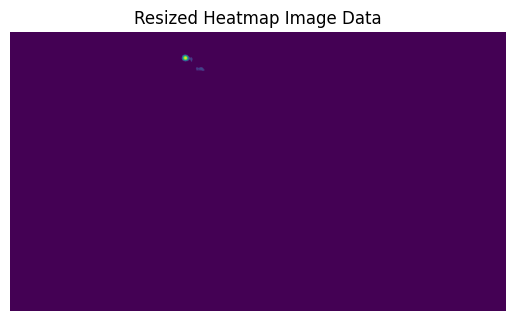

In [379]:
heatmap_filter = (heatmap_resized > 0.11).astype(np.float32) * heatmap_resized
# 显示图像
plt.imshow(heatmap_filter)  # 再次转换为 [720, 1280, 3] 格式
plt.title("Resized Heatmap Image Data")
plt.axis("off")
plt.show()

In [375]:
num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats((heatmap_filter > 0).astype(np.uint8), connectivity=8)

In [376]:
num_labels

3

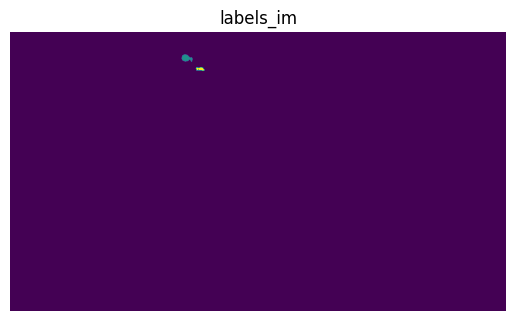

In [377]:
plt.imshow(labels_im)  # 再次转换为 [720, 1280, 3] 格式
plt.title("labels_im")
plt.axis("off")
plt.show()

In [388]:
mask = labels_im == 2
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [389]:
blob_sum = heatmap_filter[mask].sum()
blob_sum

19.677568

In [390]:
center_x = np.sum(np.where(mask)[1] * heatmap_filter[mask]) / blob_sum
center_x

490.4992713272326

In [391]:
center_y = np.sum(np.where(mask)[0] * heatmap_filter[mask]) / blob_sum
center_y

94.9891175291854

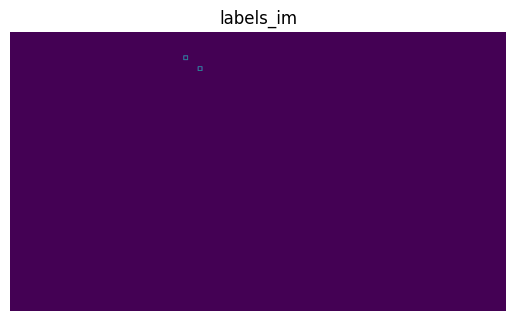

In [392]:
# 在图像上绘制正方形（矩形），使用白色（255）表示
top_left = (int(center_x - 5), int(center_y - 5))
bottom_right = (int(center_x + 5), int(center_y + 5))
cv2.rectangle(heatmap_filter, top_left, bottom_right, 220)  # -1 表示填充矩形

plt.imshow(heatmap_filter)  # 再次转换为 [720, 1280, 3] 格式
plt.title("labels_im")
plt.axis("off")
plt.show()